In [334]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

In [335]:
EV_Stations = pd.DataFrame(pd.read_csv('predicted_stations.csv'))
EV_Grid = pd.DataFrame(pd.read_csv('predicted_grid.csv'))

In [336]:
EV_Stations = EV_Stations.drop(columns='Unnamed: 0')
EV_Stations = EV_Stations.loc[(EV_Stations['Year'] >= 2010) & (EV_Stations['Year'] <= 2022)]
EV_Stations 

,Year,Total_Installed
2,2010,7.0
3,2011,57.0
4,2012,38.0
5,2013,16.0
6,2014,38.0
7,2015,65.0
8,2016,81.0
9,2017,97.0
10,2018,106.0
11,2019,174.0


In [337]:
EV_Vehicles = pd.DataFrame(pd.read_csv('predicted_vehicles.csv'))
EV_Vehicles = EV_Vehicles.drop(columns='Unnamed: 0')
EV_Vehicles = EV_Vehicles.loc[(EV_Vehicles['Year'] >= 2010) & (EV_Vehicles['Year'] <= 2022)]
EV_Vehicles

,Year,Total_Sold
0,2010,3.0
1,2011,13.0
2,2012,14.0
3,2013,19.0
4,2014,17.0
5,2015,32.0
6,2016,38.0
7,2017,64.0
8,2018,100.0
9,2019,147.0


In [338]:
EV_Grid = EV_Grid.drop(columns='Unnamed: 0')
EV_Grid = EV_Grid.loc[(EV_Grid['Year'] >= 2010) & (EV_Grid['Year'] <= 2022)]
EV_Grid

,Predicted_MWH,Year
20,1.034727e+08,2010
21,1.152626e+08,2011
22,1.168355e+08,2012
23,1.141729e+08,2013
24,1.163344e+08,2014
25,1.092875e+08,2015
26,1.140866e+08,2016
27,1.159121e+08,2017
28,1.167567e+08,2018
29,1.064636e+08,2019


In [339]:
import math

# create a copy of the ev_grid array
ev_grid_scaled = EV_Grid.copy()

# select the predicted column
predicted_column = ev_grid_scaled['Predicted_MWH']

# scale the ev_grid value for all rows except the last row
predicted_column[:-1] = predicted_column[:-1] / math.exp(8)

# multiply the last row by e^7
#predicted_column[-1] = predicted_column[-1] * math.exp(7)
last_row = ev_grid_scaled.tail(1)
last_row = last_row / math.exp(7)
# change the last row of the predicted column
ev_grid_scaled.iloc[-1, ev_grid_scaled.columns.get_loc('Predicted_MWH')] = last_row
# update the predicted column in the ev_grid_scaled array
ev_grid_scaled['Predicted_MWH'] = predicted_column


ev_grid_scaled['Predicted_MWH'] = ev_grid_scaled['Predicted_MWH'].astype(int)
EV_Grid=ev_grid_scaled

EV_Grid

,Predicted_MWH,Year
20,34711,2010
21,38666,2011
22,39193,2012
23,38300,2013
24,39025,2014
25,36661,2015
26,38271,2016
27,38884,2017
28,39167,2018
29,35714,2019


In [340]:
print(EV_Vehicles.shape)
print(EV_Stations.shape)
print(EV_Grid.shape)

(13, 2)
(13, 2)
(13, 2)


In [341]:
# split the data into X (features) and y (target)
df = pd.merge(EV_Stations, EV_Grid, on='Year')
X = np.array(df[['Total_Installed', 'Predicted_MWH']])
y = np.array(EV_Stations['Year'])
print(X)
print(y)

[[7.0000e+00 3.4711e+04]
 [5.7000e+01 3.8666e+04]
 [3.8000e+01 3.9193e+04]
 [1.6000e+01 3.8300e+04]
 [3.8000e+01 3.9025e+04]
 [6.5000e+01 3.6661e+04]
 [8.1000e+01 3.8271e+04]
 [9.7000e+01 3.8884e+04]
 [1.0600e+02 3.9167e+04]
 [1.7400e+02 3.5714e+04]
 [2.0600e+02 3.8952e+04]
 [6.8300e+02 3.7172e+04]
 [2.6400e+02 2.9399e+04]]
[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [342]:
import torch
from torch import nn

num_inputs = 2
num_outputs = 1

hidden_size = [32, 64, 128, 256]

model = nn.Sequential(
nn.Linear(num_inputs, hidden_size[0]),
nn.ReLU(),
nn.Linear(hidden_size[0], hidden_size[1]),
nn.ReLU(),
nn.Linear(hidden_size[1], hidden_size[2]),
nn.ReLU(),
nn.Linear(hidden_size[2], hidden_size[3]),
nn.ReLU(),
nn.Linear(hidden_size[3],num_outputs),
)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# create an instance of the MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

y=y.reshape(-1,1)

# fit the scaler to the data
scaler_x.fit(X)
scaler_y.fit(y)

# transform the data
X = scaler_x.transform(X)
y = scaler_y.transform(y)

# normalize and scale the data
X_mean = X.mean()
X_std = X.std()
y_mean = y.mean()
y_std = y.std()

X = (X - X_mean) / X_std
y = (y - y_mean) / y_std
print(y.shape)
print(X.shape)
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# convert the data to tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
print(X_train)
print(y_train)

(13, 1)
(13, 2)
tensor([[-0.9156,  1.1729],
        [-1.1338,  1.2089],
        [-1.1338,  1.2518],
        [-1.2151,  1.0238],
        [-0.8823,  1.2451],
        [ 1.2518,  0.7359],
        [-1.0339,  0.6054],
        [-0.6308,  0.3637],
        [-0.9747,  1.0164],
        [-1.2484,  0.1076]])
tensor([[ 2.6726e-01],
        [-5.3452e-01],
        [-1.0690e+00],
        [-8.0178e-01],
        [ 5.3452e-01],
        [ 1.3363e+00],
        [-2.6726e-01],
        [ 8.0178e-01],
        [ 2.8129e-14],
        [-1.6036e+00]])


In [343]:

# define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
print(model)
# train the model
for epoch in range(1000):
    # forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print training and testing accuracy
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/1000: Training loss = {loss.item():.4f}')
        with torch.no_grad():
            y_pred_test = model(X_test)
            test_loss = criterion(y_pred_test, y_test)
            print(f'Epoch {epoch+1}/1000: Testing loss = {test_loss.item():.4f}')

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=1, bias=True)
)
Epoch 1/1000: Training loss = 0.7479
Epoch 1/1000: Testing loss = 2.2832
Epoch 101/1000: Training loss = 0.0563
Epoch 101/1000: Testing loss = 1.0295
Epoch 201/1000: Training loss = 0.0162
Epoch 201/1000: Testing loss = 1.1166
Epoch 301/1000: Training loss = 0.0613
Epoch 301/1000: Testing loss = 1.2470
Epoch 401/1000: Training loss = 0.0146
Epoch 401/1000: Testing loss = 1.3062
Epoch 501/1000: Training loss = 0.0394
Epoch 501/1000: Testing loss = 1.3164
Epoch 601/1000: Training loss = 0.0205
Epoch 601/1000: Testing loss = 1.4760
Epoch 701/1000: Training loss = 0.0126
Epoch 701/1000: Testing loss = 1.3495
Epoch 801/1000: Training l

In [344]:
# create a new data point
X_new = pd.DataFrame({'Year': [2023], 'EV_stations': [264.0]})

# convert the data to a tensor
X_new = torch.from_numpy(X_new.values).float()

# normalize and scale the data
#X_new = (X_new - X_mean) / X_std

# make predictions using the model
y_pred = model(X_new)

# de-normalize the prediction
y_pred = y_pred * y_std + y_mean

print(f'Predicted grid power for 2033 with 1574 EV stations: {y_pred.item():.4f}')

Predicted grid power for 2033 with 1574 EV stations: 231.7696


In [364]:
# create a new data point
X_new = pd.DataFrame({'Year': [2023], 'EV_stations': [238.11287478]})

year = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033]
stations = [238.11287478,
 256.39153439, 274.670194,   292.94885362, 311.22751323, 329.50617284, 347.78483245, 366.06349206, 384.34215168, 402.62081129,
  420.8994709]


# convert the data to a tensor
X_new = torch.from_numpy(X_new.values).float()

# normalize and scale the data
#X_new = (X_new - X_mean) / X_std

# make predictions using the model
y_pred = model(X_new)

# de-normalize the prediction
y_pred = y_pred * y_std + y_mean

import math

# multiply the number by e^4
result = y_pred.item() * math.exp(5)
result
print(f'Predicted grid power for 2023 with 238 EV stations: {result:.4f}')

Predicted grid power for 2023 with 238 EV stations: 34033.2009


In [365]:
import pandas as pd
import torch
import math

# Define the year and number of stations lists
year = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033]
stations = [238.11287478,
 256.39153439, 274.670194,   292.94885362, 311.22751323, 329.50617284, 347.78483245, 366.06349206, 384.34215168, 402.62081129,
  420.8994709]

# Create empty lists to store the predictions
predictions = []

# Iterate over the year and number of stations lists
for i in range(len(year)):
    # Create a new data point
    X_new = pd.DataFrame({'Year': [year[i]], 'EV_stations': [stations[i]]})

    # Convert the data to a tensor
    X_new = torch.from_numpy(X_new.values).float()

    # Normalize and scale the data
    #X_new = (X_new - X_mean) / X_std

    # Make predictions using the model
    y_pred = model(X_new)

    # De-normalize the prediction
    y_pred = y_pred * y_std + y_mean

    # Multiply the prediction by e^4
    result = y_pred * math.exp(5)
    
    # Add the prediction to the list
    predictions.append(result.item())

# Print the predictions
print(predictions)

[34033.203125, 34305.65625, 34578.109375, 34850.56640625, 35123.53125, 35397.640625, 35671.75390625, 35945.859375, 36219.96875, 36494.08203125, 36768.1953125]


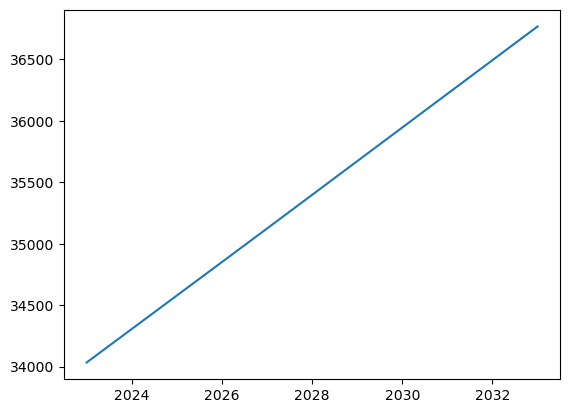

In [371]:
plt.plot(year,predictions)

In [375]:
EV_Grid

,Predicted_MWH,Year
20,34711,2010
21,38666,2011
22,39193,2012
23,38300,2013
24,39025,2014
25,36661,2015
26,38271,2016
27,38884,2017
28,39167,2018
29,35714,2019


Text(0, 0.5, 'Capacity in MWH')

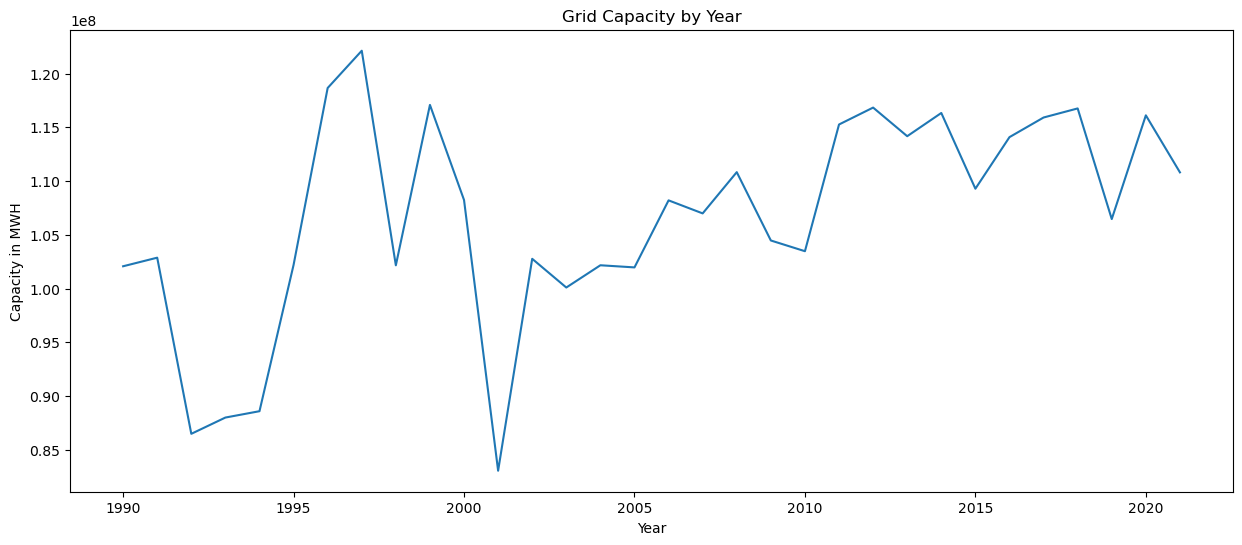

In [381]:
#x=X_train
#y=y_train
df = pd.DataFrame(pd.read_csv('annual_generation_WA.csv'))

x= np.arange(32) + 1990

y = df.Total.values


n = np.size(x)
   
fig=plt.figure(figsize = (15,6))
plt.title('Grid Capacity by Year')
plt.plot(x,y)
plt.xlabel('Year')
plt.ylabel('Capacity in MWH')